In [4]:
%matplotlib inline

import numpy as np# libreria para el manejo de matrices y vectores
import matplotlib.pyplot as plt #para graficar
import math #librería matemática
import cv2  #Manejo de imagenes usando opencv
#para que funcione conda install opencv
#from PIL import Image #libreria para bel manejo de imagenes tambien conocida como Pillow
#pip install pillow o conda install pillow
#anaconda en el ambiente root lo trae preparado
import time# desde la raiz importamos la libreria

#from tensorflow.keras.models import load_model
#para instalar en anaconda tensorflow, las ultimas versiones vienen con el paquete sólo hay que habilitarlo en el ambiente



In [8]:
#funciones globales
def read_image(path):
    imagen = cv2.imread(path)#path es la dirección absoluta o relativa según el sistema operativo
    #imread carga la imagen en formato vector
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)#convierte en escala de grises la foto.
    #utiliza algo similar al algoritmo de Cammy
    return imagen

def plot_image(image, title=''):
    fig = plt.figure(figsize = (8,8))#crea una figura, vector, 8,8
 #   print(fig.shape)
    ax1 = fig.add_subplot(111)#crea una seccion de 1,1,1 en el plot
    ax1.set_xticks([])#fijar las coordenadas del plot en 0.0
    ax1.set_yticks([])

    ax1.set_title(title)#fija en vacio el titulo del plot si no viene con parámetro
    ax1.imshow(image)#muestra la imagen
    
def get_faces(image):
    # la idea es recorrer la imagen encontrar patrones e identificar cuando y donde hay una cara
    image_copy = np.copy(image)
    
    #vector con la escala de grises de la imagen
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    #al existir un preentrenado modelo en un xml simplemente lo carga
    face_classifier = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
    
    # Detect the faces in image
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)#busca en gray los patrones que están en face_classifier
    
    return faces #regresa un arreglo de caras

def draw_faces(image, faces=None, plot=True):
    if faces is None:
        faces = get_faces(image)# en caso que no haya sido procesada la imagen se buscan las caras nuevamente
    
    image_with_faces = np.copy(image)
    
    for (x,y,w,h) in faces:
        #tupla con cuatro coordenadas en el plano cartesiano
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (255,0,0), 3)#dibuja un cuadrado rojo desde el punto x,y
        
    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces

def plot_image_with_keypoints(image, image_info):
   
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (face, keypoints) in image_info:#busca la informacion en un diccionario y la pone en la foto
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)
   

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)
    # este metodo hay que probarlo bien


Faces detected: 8


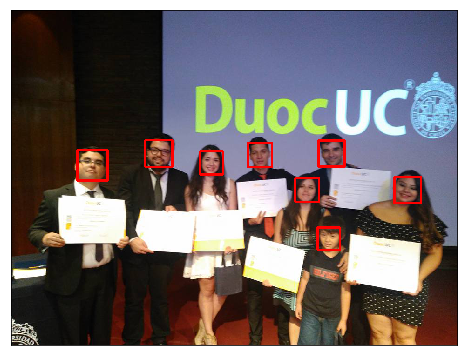

In [13]:
#para probar hasta aqui
image = read_image('3.jpg')
faces = get_faces(image)
print("Faces detected: {}".format(len(faces)))
draw_faces(image, faces)
for(x,y,w,h) in faces:
    crop_img = image[y:y+h, x:x+w]
    cv2.imshow("cropped", crop_img)
    cv2.waitKey(0)